# Credit Card Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import 

### Step 1: Importing & Understanding the dataset

In [2]:
credit_card_df = pd.read_csv('datasets/Credit_card_dataset.csv')
credit_card_df.head()

,CUST_ID,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,C10001,0.818182,95.40,201.802084,1000.0,0.000000
1,C10002,0.909091,0.00,4103.032597,7000.0,6442.945483
2,C10003,1.000000,773.17,622.066742,7500.0,0.000000
3,C10004,0.636364,1499.00,0.000000,7500.0,205.788017
4,C10005,1.000000,16.00,678.334763,1200.0,0.000000


In [3]:
credit_card_df.shape

(8950, 6)

In [4]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CUST_ID            8950 non-null   object 
 1   BALANCE_FREQUENCY  8950 non-null   float64
 2   PURCHASES          8950 non-null   float64
 3   PAYMENTS           8950 non-null   float64
 4   CREDIT_LIMIT       8949 non-null   float64
 5   CASH_ADVANCE       8950 non-null   float64
dtypes: float64(5), object(1)
memory usage: 419.7+ KB


In [5]:
credit_card_df.describe(include='all')

,CUST_ID,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
count,8950,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000
unique,8950,NaN,NaN,NaN,NaN,NaN
top,C10001,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.877271,1003.204834,1733.143852,4494.449450,978.871112
std,NaN,0.236904,2136.634782,2895.063757,3638.815725,2097.163877
min,NaN,0.000000,0.000000,0.000000,50.000000,0.000000
25%,NaN,0.888889,39.635000,383.276166,1600.000000,0.000000
50%,NaN,1.000000,361.280000,856.901546,3000.000000,0.000000
75%,NaN,1.000000,1110.130000,1901.134317,6500.000000,1113.821139


In [6]:
# check if there are blank values
credit_card_df.isnull().sum()

CUST_ID              0
BALANCE_FREQUENCY    0
PURCHASES            0
PAYMENTS             0
CREDIT_LIMIT         1
CASH_ADVANCE         0
dtype: int64

In [7]:
# check duplicated values
credit_card_df.duplicated().sum()

np.int64(0)

There are 8950 rows with 6 columns. The columns are mostly numerical with only the CUST_ID is categorical.
There is 1 missing value in the credit_limit column
There are no duplicates in the dataframe

### Step 2: Data Preprocessing

#### 2.1 Filling in missing values on CREDIT_LIMIT

In [8]:
# Filling in missing values on CREDIT_LIMIT
df = credit_card_df.copy()
df.columns = df.columns.str.lower()
missing = df[df.credit_limit.isnull()]
missing

,cust_id,balance_frequency,purchases,payments,credit_limit,cash_advance
5203,C15349,0.166667,0.0,9.040017,NaN,186.853063


In [9]:
df[df.payments < 1].value_counts()

cust_id  balance_frequency  purchases  payments  credit_limit  cash_advance
C10004   0.636364           1499.00    0.0       7500.0        205.788017      1
C16963   0.545455           21.99      0.0       4000.0        0.000000        1
C15924   0.000000           1021.56    0.0       3000.0        0.000000        1
C15944   0.090909           0.00       0.0       1800.0        93.468447       1
C15949   0.000000           102.72     0.0       1500.0        0.000000        1
                                                                              ..
C11379   0.000000           300.00     0.0       2500.0        0.000000        1
C11624   1.000000           0.00       0.0       3000.0        1820.800715     1
C11675   0.090909           0.00       0.0       12000.0       1125.868686     1
C11705   0.090909           0.00       0.0       1000.0        575.193978      1
C19185   0.833333           1012.73    0.0       4000.0        0.000000        1
Name: count, Length: 242, dtype: 

In [10]:
df[df.payments < 1].credit_limit.mean()

np.float64(3908.471074380165)

Given there are many factors that affect credit limits, we'll assign the missing values a credit limit based off the average of the limits for people with payments less than 1. The reason we're utilising payments is because we're able to get lesser groupings as opposed to the other columns which are quite random

In [11]:
df.loc[5203, 'credit_limit'] = 3908.47

In [12]:
df.credit_limit.isnull().sum()

np.int64(0)

#### 2.2 Data analysis

1. Does balance frequency influence the credit limit amount?
2. Does making high purchase amounts and payments frequency affect the cash advance and credit limit?

#### 2.3 Checking and handling outliers

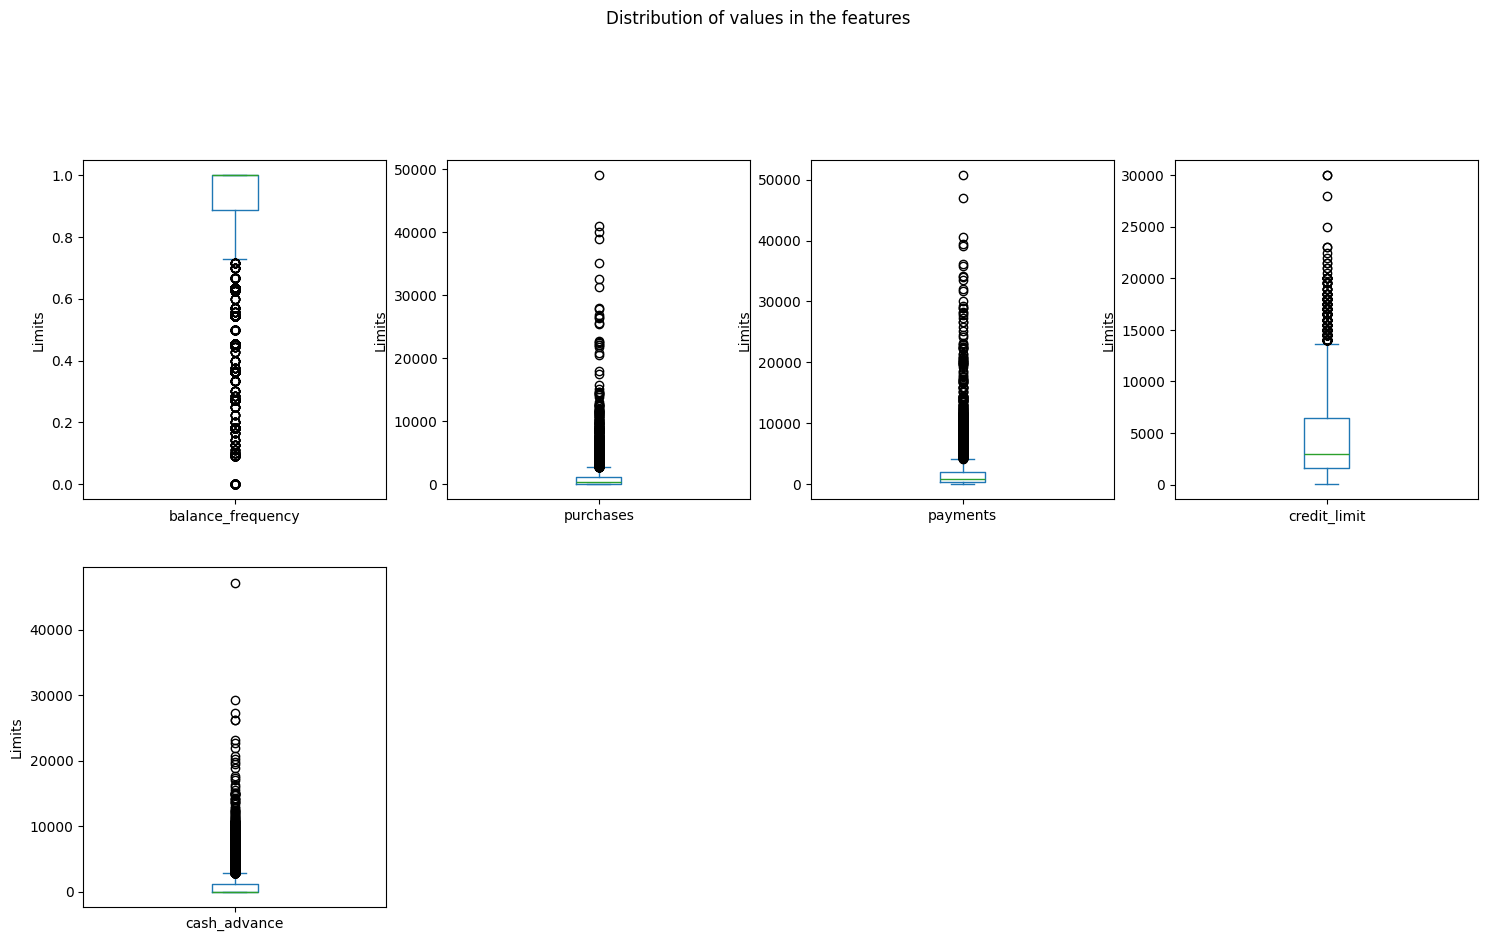

In [13]:
# Create a boxplot to see the distribution of data basing on the upper and lower percentiles
df.plot(kind ='box', subplots=True, figsize=(18,15), layout =(3,4), ylabel='Limits', title='Distribution of values in the features')
plt.show()

There are a few outliers in the dataset. To handle the outliers in our dataset we'll use the InterQuartile Range method and cap the values to fit the IQR upper and lower limits

#### Using IQR Method to handle the outliers

In [14]:
def outlier_limits(col):
    Q3, Q1 = np.nanpercentile(col, [75,25])
    inter_quartile_range = Q3 - Q1
    upper_limit = Q3 + (1.5*inter_quartile_range)
    lower_limit = Q1 - (1.5*inter_quartile_range)
    return upper_limit, lower_limit

In [15]:
new_df = df.copy()
for col in new_df.columns:
    if new_df[col].dtype != 'object':
        UL, LL = outlier_limits(new_df[col])
        new_df.loc[(new_df[col] > UL), col] = UL
        new_df.loc[(new_df[col] < LL), col] = LL

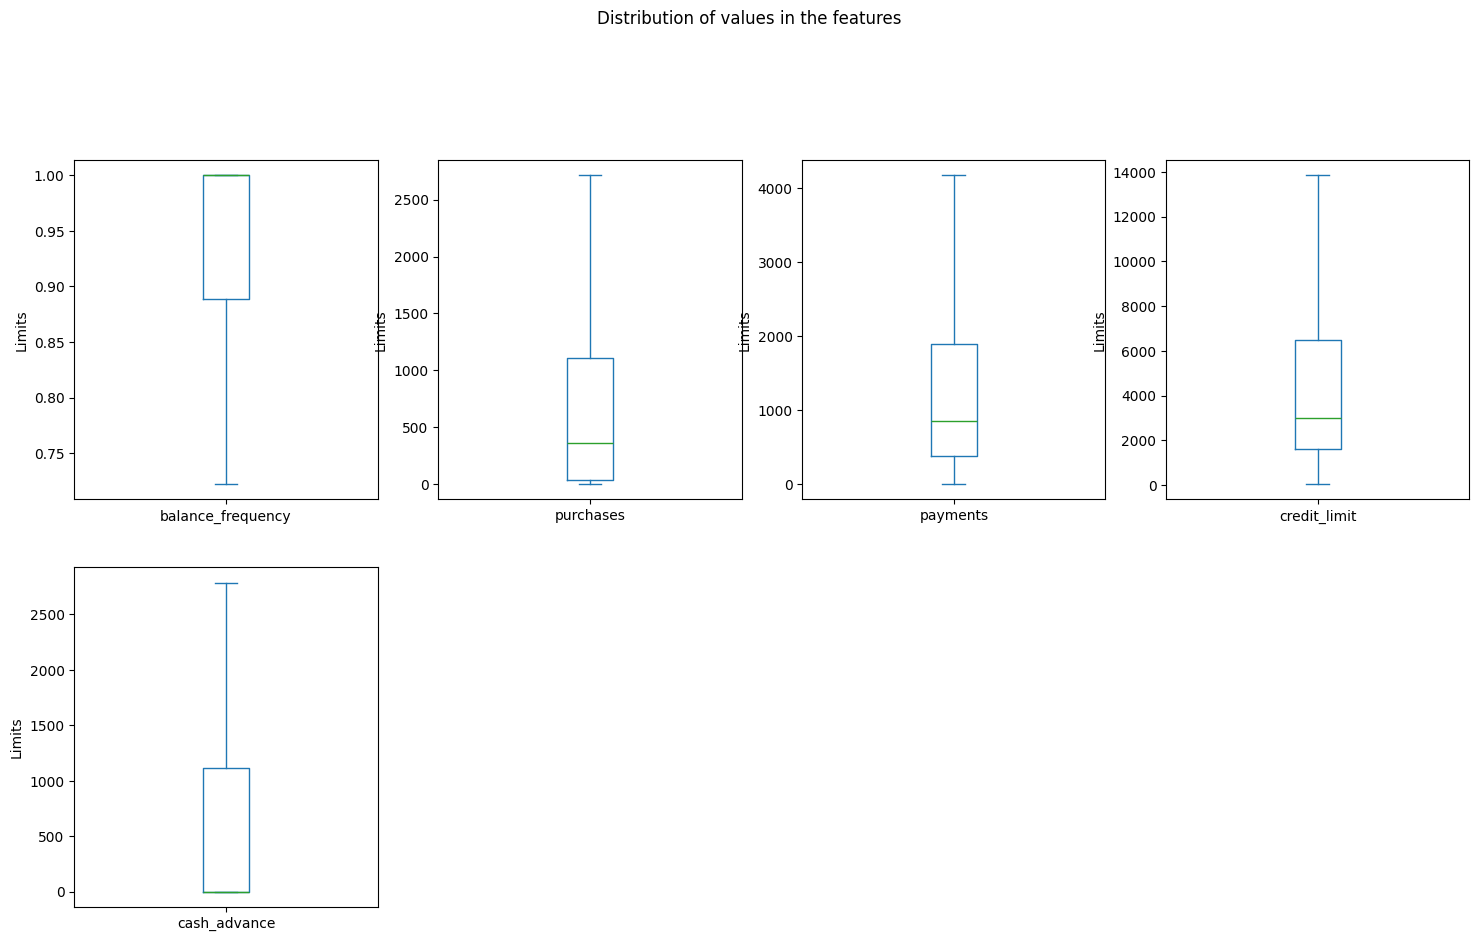

In [16]:
# Create a boxplot to see the distribution of data basing on the upper and lower percentiles
new_df.plot(kind ='box', subplots=True, figsize=(18,15), layout =(3,4), ylabel='Limits', title='Distribution of values in the features')
plt.show()

In [17]:
print('Before handling outliers', len(df))
print('After handling outliers', len(new_df))
print('Outliers handled', len(df) - len(new_df))

Before handling outliers 8950
After handling outliers 8950
Outliers handled 0


The interquartile range (IQR) helps identify how how spread out the middle 50% of a dataset is by focusing on the central part, ignoring any extreme values or outliers. In handling the credit card data outliers we're capping them to be between 1.5 of the upper and lower quartiles while still retaining the total values in our dataset

#### 2.4 Encoding the categorical columns

In [18]:
new_df.cust_id.nunique()

8950

The cust_id is the only categorical column in our dataset. For our model, we don't require it as it maps out all the unique customers and might make a lot of noise, therefore, we'll drop it

In [19]:
new_df = new_df.drop('cust_id', axis=1)

#### 2.5 Checking the correlation in our data

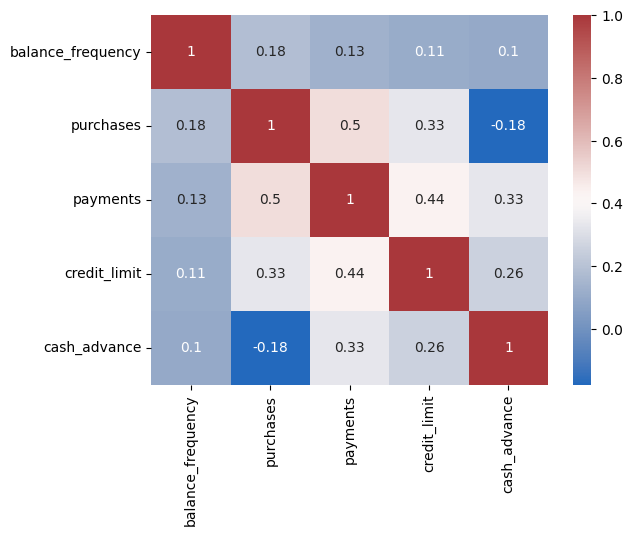

In [20]:
sns.heatmap(data = new_df.corr(), annot=True, cmap='vlag')
plt.show()

Basing on correlation of the data, payments have a moderately positive correlation to the credit limit with the purchases and cash advance also having a positive correlation to it.

#### 2.6 Standardize/normalize our data

For clustering algorithms, it's important to standardize data so that they are on the same scale as it helps in calculating the distance between the identified groups

#### Checking the distribution of our data
Helps in identifying the best scaling method to use.

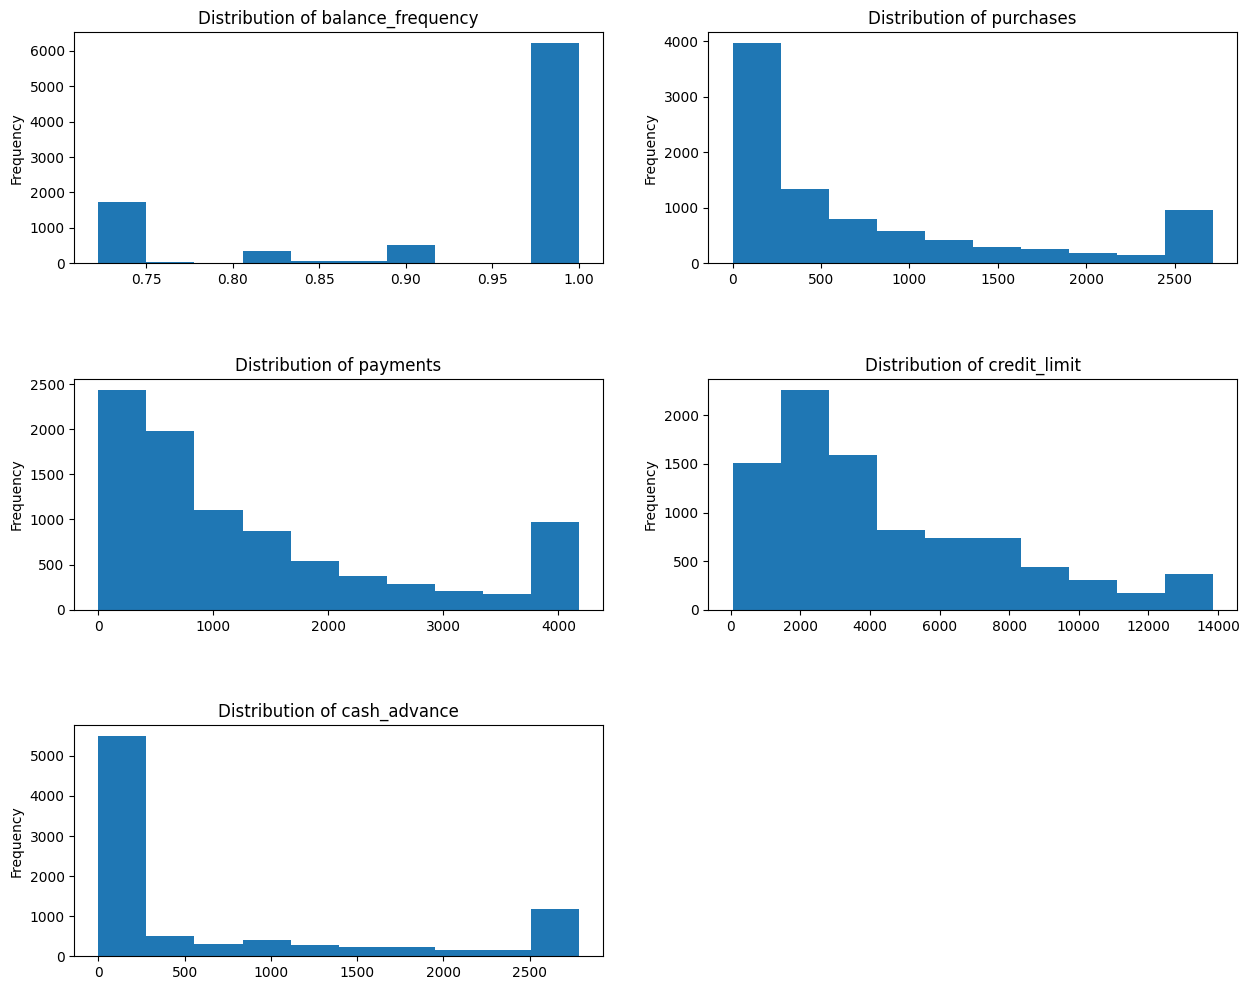

In [27]:
# Showing the distribution of data on the columns with original data
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
for i, col in enumerate(new_df.columns):
    ax = plt.subplot(3,2, i + 1)
    new_df[col].plot.hist(ax=ax)
    ax.set_title('Distribution of {}'.format(col))
    ax.set_xlabel("")

The distribution of data in each of the columns is non-linear. Therefore, since we want to cluster our data we'll need to scale our data to reduce the elucidian distance when training our clustering algorithm. We can use the normalization and standardization methods to check how each will affect the results of our clustering algorithm

In [28]:
# Checking our data
new_df.head(1)

,balance_frequency,purchases,payments,credit_limit,cash_advance
0,0.818182,95.4,201.802084,1000.0,0.0


#### Feature Scaling - Normalization 

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
# Using MinMaxScalar to scale our data
minmax_scaler = MinMaxScaler().fit(new_df)
minmax_scaler_df = pd.DataFrame(minmax_scaler.transform(new_df), columns=new_df.columns)


In [43]:
minmax_scaler_df.describe()

,balance_frequency,purchases,payments,credit_limit,cash_advance
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,0.753713,0.271423,0.322429,0.316612,0.241500
std,0.399541,0.323850,0.304651,0.245200,0.358591
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.600000,0.014594,0.091738,0.112319,0.000000
50%,1.000000,0.133025,0.205102,0.213768,0.000000
75%,1.000000,0.408756,0.455043,0.467391,0.400000
max,1.000000,1.000000,1.000000,1.000000,1.000000


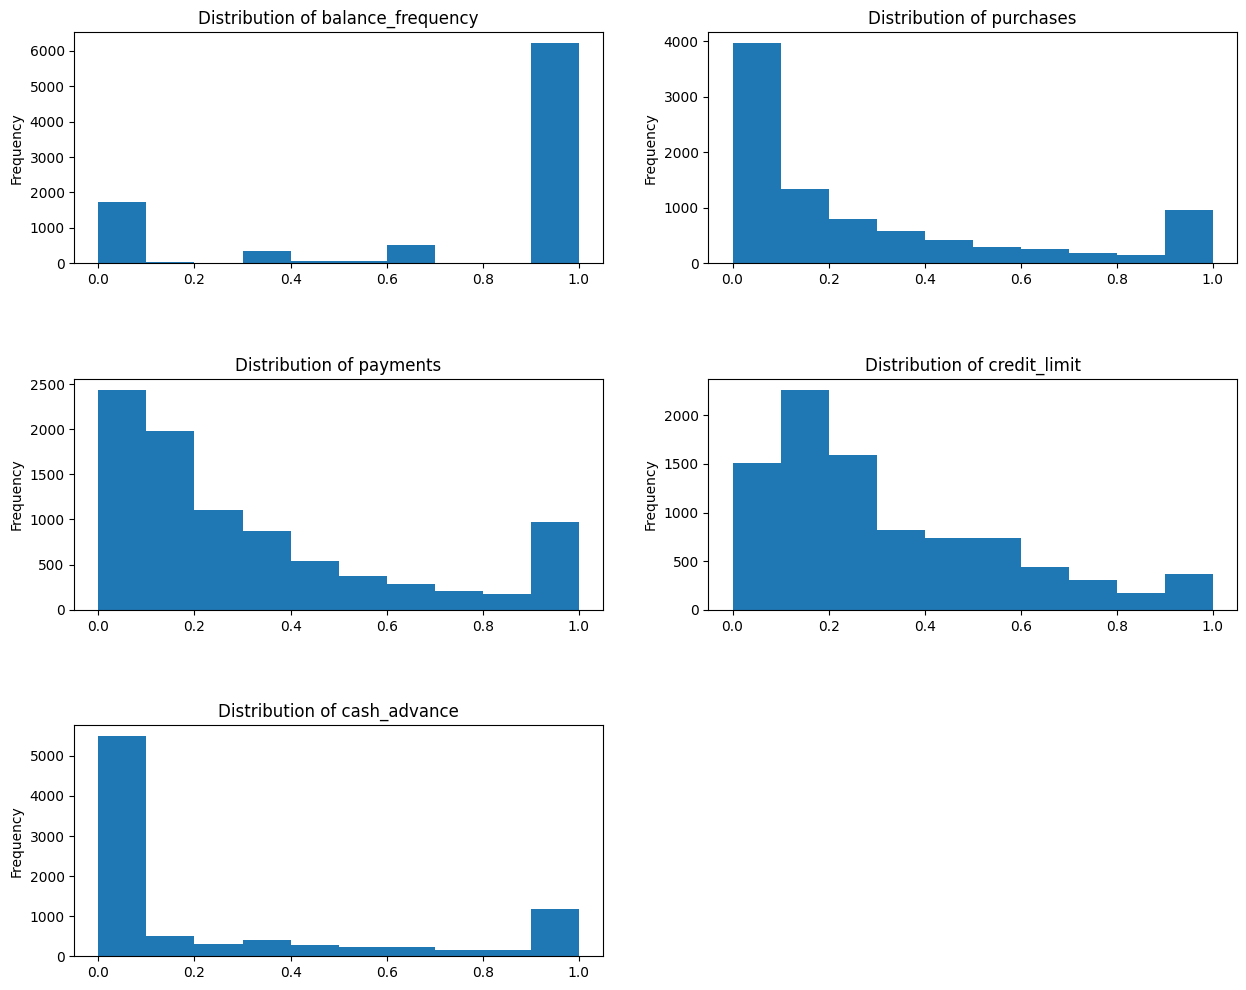

In [44]:
# Showing the distribution of data on the columns with scaled data
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
for i, col in enumerate(minmax_scaler_df.columns):
    ax = plt.subplot(3,2, i + 1)
    minmax_scaler_df[col].plot.hist(ax=ax)
    ax.set_title('Distribution of {}'.format(col))
    ax.set_xlabel("")

#### Feature Scaling: Standardization

In [45]:
from sklearn.preprocessing import StandardScaler

In [47]:
# Using StandardScaler to scale our data
standard_scaler = StandardScaler().fit(new_df)
standard_scaler_df = pd.DataFrame(standard_scaler.transform(new_df), columns=new_df.columns)


In [48]:
standard_scaler_df.describe()

,balance_frequency,purchases,payments,credit_limit,cash_advance
count,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03
mean,-1.244839e-15,1.460781e-16,8.256586e-17,2.540488e-17,5.874878e-17
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00
min,-1.886552e+00,-8.381596e-01,-1.058417e+00,-1.291310e+00,-6.735067e-01
25%,-3.847451e-01,-7.930935e-01,-7.572730e-01,-8.332141e-01,-6.735067e-01
50%,6.164594e-01,-4.273740e-01,-3.851411e-01,-4.194500e-01,-6.735067e-01
75%,6.164594e-01,4.240895e-01,4.353224e-01,6.149602e-01,4.420333e-01
max,6.164594e-01,2.249864e+00,2.224216e+00,2.787222e+00,2.115343e+00


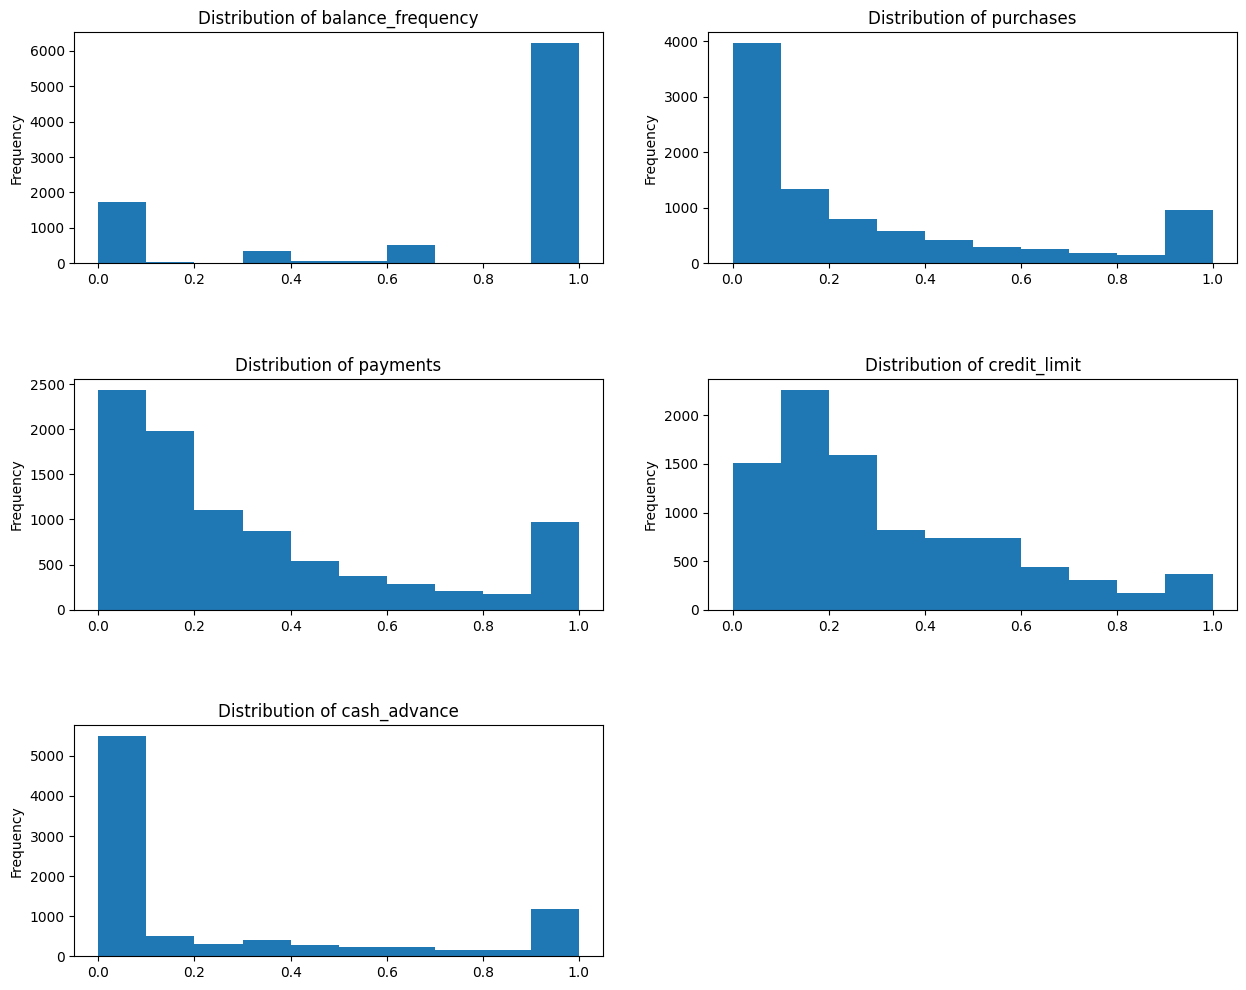

In [49]:
# Showing the distribution of data on the columns with scaled data
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
for i, col in enumerate(minmax_scaler_df.columns):
    ax = plt.subplot(3,2, i + 1)
    minmax_scaler_df[col].plot.hist(ax=ax)
    ax.set_title('Distribution of {}'.format(col))
    ax.set_xlabel("")

### Step 3: Training our models